In [15]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()

In [16]:
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
from halotools.empirical_models import NFWPhaseSpace, Zheng07Sats
from halotools.sim_manager import CachedHaloCatalog
from src.redMagicHOD import RedMagicCens, RedMagicSats, StepFuncCens, StepFuncSats

In [17]:
rz = 0.0
cens_prof_model = TrivialPhaseSpace(redshift = rz)
sats_prof_model = NFWPhaseSpace(redshift = rz)
model_instance = HodModelFactory(
        #centrals_occupation = StepFuncCens(redshift = rz),
        centrals_occupation = RedMagicCens(redshift = rz),
        centrals_profile = cens_prof_model,
        #satellites_occupation = StepFuncSats(redshift = rz),
        satellites_occupation = RedMagicSats(redshift = rz),
        satellites_profile = sats_prof_model)

In [29]:
print model_instance.param_dict

{'logMmin': 12.02, 'f_c': 0.19, 'logM0': 11.38, 'sigma_logM': 0.26, 'logM1': 13.31, 'alpha': 1.06}


In [18]:
#model_instance.param_dict['logMmin'] = 13.1

In [19]:
simname = 'emu'
rz = 0.0
version_name = 'most_recent'
size = (1050.0)**3
halocat= CachedHaloCatalog(simname = simname, halo_finder = 'rockstar',version_name = version_name, redshift = rz)

In [20]:
model_instance.populate_mock(halocat, Num_ptcl_requirement = 0)

In [21]:
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import group_member_generator

halos = model_instance.mock.halo_table

#halos = halos[halos['halo_mvir']> 7e12]

halos.sort(['halo_id', 'halo_upid'])
grouping_key = 'halo_id'
requested_columns = ['halo_num_centrals', 'halo_num_satellites', 'halo_mvir']
group_gen = group_member_generator(halos, grouping_key, requested_columns)

ncen = []
nsat = []
mass = []

for first, last, member_props in group_gen:

    ncen.append(member_props[0][0])
    nsat.append(member_props[1][0])
    mass.append(member_props[2][0]) 
    
ncen = np.array(ncen)
nsat = np.array(nsat)
mass = np.array(mass)

In [22]:
from halotools.mock_observables import mean_y_vs_x
xmin, xmax = 1e11, 1e16
ymin, ymax = 0, 70
halo_mass = np.logspace(np.log10(xmin),np.log10(xmax),100) #bad name, actually mass bins. 

binned_logmass, ncen_hat, ncen_err= mean_y_vs_x(mass, ncen, bins = halo_mass, error_estimator = 'variance')
binned_logmass, nsat_hat, nsat_err= mean_y_vs_x(mass, nsat, bins = halo_mass, error_estimator = 'variance')

nhalo_binned, be = np.histogram(mass, halo_mass)

In [23]:
mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

In [24]:
print sum(ncen/size - np.ones(mass.shape)/size), sum(nsat/size), 

-0.00661871590612 0.00147789655544


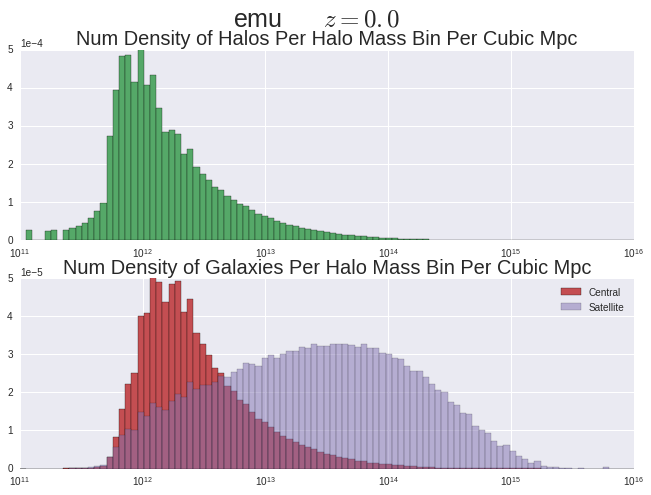

In [27]:
fig = plt.figure(figsize = (11,7.5))

plt.subplot(211)
plt.title("Num Density of Halos Per Halo Mass Bin Per Cubic Mpc",fontsize = 20)

plt.hist(mass, halo_mass, weights = np.ones(mass.shape)/size, color = colors[1])
plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y',scilimits=(0,0))

plt.xlim([xmin,xmax])
plt.ylim([0, 5e-4])

plt.subplot(212)
plt.title("Num Density of Galaxies Per Halo Mass Bin Per Cubic Mpc",fontsize = 20)
plt.hist(mass, halo_mass,weights = ncen/size, color = colors[2], label = 'Central')
plt.hist(mass, halo_mass,weights = nsat/size, color = colors[3], alpha = 0.5, label = 'Satellite')
plt.legend(loc = 'best')

plt.xscale('log')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlim([xmin,xmax])
plt.ylim([0, 5e-5])

plt.suptitle('%s\t $z = %.1f$'%(simname, rz), fontsize = 25)

plt.show()